Using a Recurrent Neural Network and dog names, it is possible to generate new dog names from the original ones. Let's start.

In [6]:
# Importing necessary packages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
from keras.utils.data_utils import get_file
import io
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [7]:
# Reading the data
names = pd.read_csv('dog_names.csv')
# Rename columns names
names = names.rename(columns={'Row_Labels' : 'name', 'Count_AnimalName' : 'count'})
# Lower the names
names['name'] = names.name.str.lower()

As some names contain numbers or non-alphabetic characters ($, %, &, #, ?...), we drop them to get more 'readable' names:

In [8]:
# Remove not alphabetic names
names = names[names['name'].str.isalpha() == True]

The 20 more common names are:

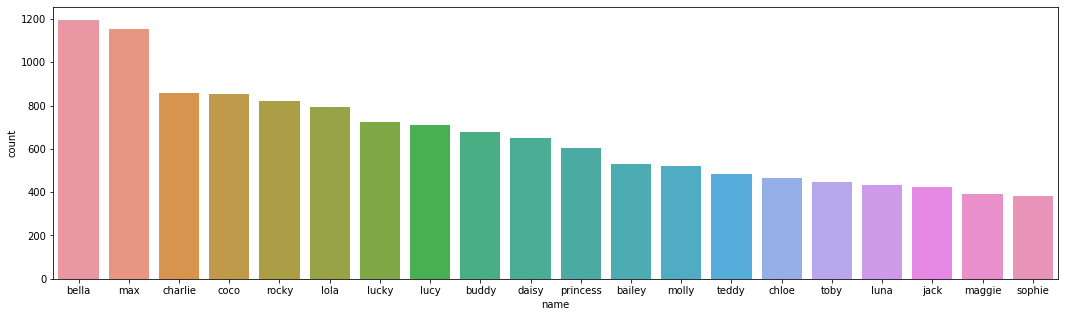

In [9]:
# Slice the 20 most common names
most_common_names = names.sort_values('count', ascending=False)[:20]
# Plot the 20 most common names
plt.figure(figsize=(18,5))
sns.barplot(x='name', y='count', data=most_common_names)

Or, using a WordCloud:

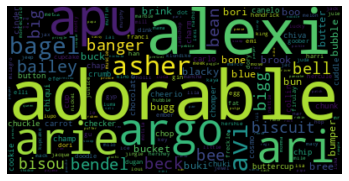

In [10]:
# Plotting a wordcloud
cloud = WordCloud().generate((' '.join(names['name'])))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

And now starts the preprocessing task, which is basic to get great results when generating names:

In [11]:
# Inserting the start token
names['data'] = names['name'].apply(lambda x : '\t' + x)
# Appending the end token
names['target'] = names['name'].apply(lambda x : x[0:len(x)] + '\n')
names = names.drop(['name'], axis=1)
names.head()

,count,data,target
7,2,\tmarch,march\n
8,51,\tapril,april\n
9,14,\taugust,august\n
10,4,\tdecember,december\n
11,13,\tsunday,sunday\n


In [12]:
# Function to create a vocabulary
def get_vocabulary(names):
    # Define the vocabulary as a set including the start and end token
    vocabulary = set(['\t', '\n'])
    # Iterate over all names and all characters of each name
    for name in names:
        for c in name:
            if c not in vocabulary:
                # If character is not in vocabulary, then add it
                vocabulary.add(c)
    # Return the vocabulary
    return vocabulary

In [13]:
# Create the vocabulary from the processed names
vocabulary = get_vocabulary(names['data'])

In [14]:
# Defining a character-to-index dictionary
char_to_idx = { char : idx for idx, char in enumerate(sorted(vocabulary))}
# Defining an index-to-character dictionary
idx_to_char = { idx : char for idx, char in enumerate(sorted(vocabulary))}

In [15]:
# Function to get the length of the longest name
def get_max_len(names):
    length_list=[]
    for l in names:
        length_list.append(len(l))
    max_len = np.max(length_list)
    return max_len

In [16]:
# Length of the longest name
max_len = get_max_len(names.data)

In [17]:
# Create and fill a 3-D vector for input
input_data = np.zeros((len(names.data), max_len+1, len(vocabulary)), dtype='float32')
for n_idx, name in enumerate(names.data):
    for c_idx, char in enumerate(name):
        input_data[n_idx, c_idx, char_to_idx[char]] = 1

In [18]:
# Create and fill a 3-D vector for target
target_data = np.zeros((len(names.target), max_len+1, len(vocabulary)), dtype='float32')
for n_idx, name in enumerate(names.target):
    for c_idx, char in enumerate(name):
        target_data[n_idx, c_idx, char_to_idx[char]] = 1

The model, a RNN, is a very simple network with only two layers, that may be improved later. As text generation can be addresed as a multi-class classification problem, the last layer of the RNN must use 'softmax' as activation function, while a categorical_crossentropy loss must be used when compiling the model.

We train during 30 epochs, using a batch_size of 128:

In [115]:
# Define the model
model = keras.models.Sequential()
model.add(keras.layers.SimpleRNN(50, input_shape=(max_len+1, len(vocabulary)), return_sequences=True))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(len(vocabulary), activation='softmax')))
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')
# Review the model
model.summary()
# Train the model with the input and target data
model.fit(input_data, target_data, batch_size=128, epochs=30)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32, 50)            4600      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 32, 41)            2091      
Total params: 6,691
Trainable params: 6,691
Non-trainable params: 0
_________________________________________________________________
Train on 15542 samples
Epoch 1/30
15542/15542 [==============================] - 3s 211us/sample - loss: 0.6355
Epoch 2/30
15542/15542 [==============================] - 2s 135us/sample - loss: 0.5622
Epoch 3/30
15542/15542 [==============================] - 2s 136us/sample - loss: 0.5414
Epoch 4/30
15542/15542 [==============================] - 2s 131us/sample - loss: 0.5297
Epoch 5/30
15542/15542 [==============================] - 2s 135us/sample - loss: 0.5227
Epoch 6/30
15542/15542 [======================

To automate the process of generating names, we construct a function with only one parameter, the number of words I want to generate:

In [116]:
# Function to generate new names
def generate_dogs_names(n):
    for i in range(0,n):
        stop=False
        counter=1
        name = ''
        # Initialize the first character of the sequence
        output_seq = np.zeros((1, max_len+1, len(vocabulary)))
        output_seq[0, 0, char_to_idx['\t']] = 1
        # Don't stop until a newline is generated or max number of characters reached
        while stop == False and counter < 10:
            # Probability distribution for the next character
            probs = model.predict_proba(output_seq, verbose=0)[:,counter-1,:]
            # Sample the vocabulary using the probability distribution
            c = np.random.choice(sorted(list(vocabulary)), replace=False, p=probs.reshape(len(vocabulary)))
            if c=='\n':
                stop=True
            else:
                # Insert the first character in the sequence
                name = name + c
                output_seq[0,counter,char_to_idx[c]] = 1
                counter=counter+1
        print(name)

And finally:

In [117]:
# Generate new names
generate_dogs_names(10)

zatin
kuz
trexwewt
leydy
mish
cisius
sbrneta
malin
chepond
ancobolk


Do they look real for you? Would you pick one of them for naming your dog?